In [60]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import shapiro
import scipy.stats as stats

In [61]:
## Read data
data=pd.read_csv('cookie_cats.csv')
data.head()

## Variables: 
# userid - a unique number that identifies each player.
# version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
# sum_gamerounds - the number of game rounds played by the player during the first week after installation.
# retention_1 - did the player come back and play 1 day after installing?
# retention_7 - did the player come back and play 7 days after installing?

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Summary Stats

In [62]:
## Check unique userids:
data.shape[0] ## data has 90189 rows
data['userid'].nunique()  ## There are 90189 unique userids

## Descriptive summary:
data.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [64]:
## Are two versions the same in terms of # gamerounds in the first week?

data.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

## There appears to be outliers

,count,median,mean,std,max
version,,,,,
gate_30,44700,17,52.456264,256.716423,49854
gate_40,45489,16,51.298776,103.294416,2640


Text(0.5, 1.0, 'Distribution of Gate 30')

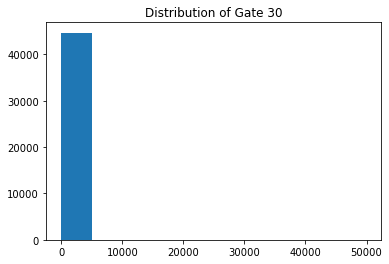

In [66]:
## Plot the distribution of sum_gamerounds for Gate 30
plt.hist(data['sum_gamerounds'][data['version']=='gate_30'])
plt.title('Distribution of Gate 30')

Text(0.5, 1.0, 'Distribution of Gate 40')

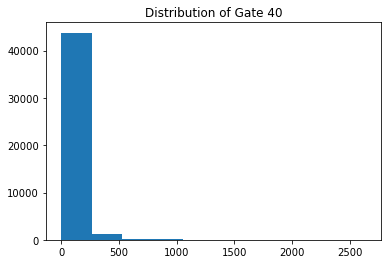

In [67]:
## Plot the distribution of sum_gamerounds for Gate 40
plt.hist(data['sum_gamerounds'][data['version']=='gate_40'])
plt.title('Distribution of Gate 40')

<AxesSubplot:xlabel='version', ylabel='sum_gamerounds'>

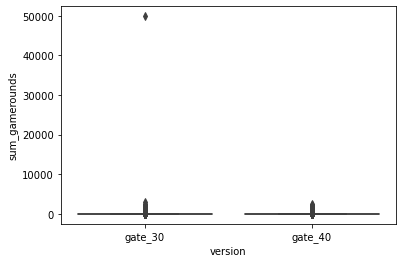

In [68]:
## Plot side-by-side boxplot to identify outliers
sns.boxplot(x="version", y="sum_gamerounds", data=data)

In [69]:
## Get rid of outliers, which is the max value
data = data[data.sum_gamerounds < data.sum_gamerounds.max()] 

<AxesSubplot:xlabel='version', ylabel='sum_gamerounds'>

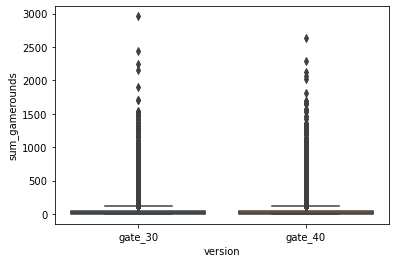

In [70]:
## Double check outliers are gone
sns.boxplot(x="version", y="sum_gamerounds", data=data)

Text(0.5, 0, '# Game rounds')

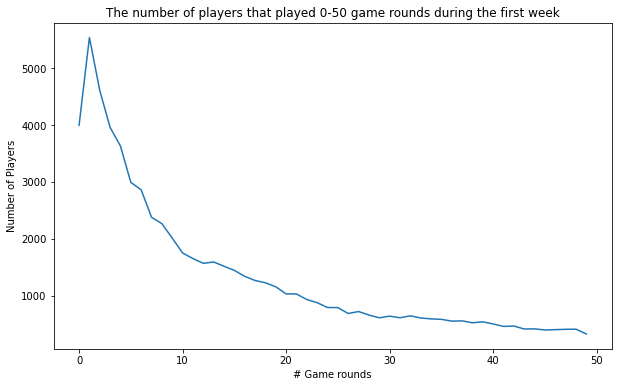

In [83]:
## What do we learn from the distribution of gamerounds ?
plot_gamerounds=data.groupby("sum_gamerounds").userid.count()
%matplotlib inline
ax = plot_gamerounds[:50].plot(figsize=(10,6))
ax.set_title("The number of players that played 0-50 game rounds during the first week")
ax.set_ylabel("Number of Players")
ax.set_xlabel('# Game rounds')

In [84]:
## 3994 users installed but never played during the first week after installation. Investigation over why those users were not even attempting to play after installation is needed.
plot_gamerounds.head()

sum_gamerounds
0    3994
1    5538
2    4606
3    3958
4    3629
Name: userid, dtype: int64

In [85]:
## 50% of users played less than 16 rounds during the first week, and 20% played less than 3 rounds.    
data.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])['sum_gamerounds']

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
1%           0.000000
5%           1.000000
10%          1.000000
20%          3.000000
50%         16.000000
80%         67.000000
90%        134.000000
95%        221.000000
99%        493.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

In [95]:
## It's important to increase the number of game rounds played during the first week after installation because it's highly related to user stickiness.
(data[['sum_gamerounds','retention_1', 'retention_7']]).corr()

,sum_gamerounds,retention_1,retention_7
sum_gamerounds,1.000000,0.380178,0.519288
retention_1,0.380178,1.000000,0.327431
retention_7,0.519288,0.327431,1.000000


In [96]:
## Two versions have similar game rounds during the first week
data.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

In [99]:
data.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

## Two groups seem simialr in terms of sum_gamerounds after removing outliers

,count,median,mean,std,max
version,,,,,
gate_30,44699,17,51.342111,102.057598,2961
gate_40,45489,16,51.298776,103.294416,2640


In [100]:
## What can we learn from retention?
data[['retention_1', 'retention_7']].mean() 
## 45% came back to play the game after 1 day and 20% came back to play after 7 days

retention_1    0.445214
retention_7    0.186056
dtype: float64

In [102]:
## Are two groups similar in terms of subclasses of retention_1?

data.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

## In subclasses of retention_1, two groups seem similar based on summary stats

count  median       mean         std   max
version retention_1                                            
gate_30 False        24665       6  16.359092   36.528426  1072
        True         20034      48  94.411700  135.037697  2961
gate_40 False        25370       6  16.340402   35.925756  1241
        True         20119      49  95.381182  137.887256  2640

In [103]:
## Are two groups similar in terms of subclasses of retention_7?

data.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

## In subclasses of retention_7, two groups seem similar based on summary stats

count  median        mean         std   max
version retention_7                                             
gate_30 False        36198      11   25.796508   43.316158   981
        True          8501     105  160.117516  179.358560  2961
gate_40 False        37210      11   25.856356   44.406112  2640
        True          8279     111  165.649837  183.792499  2294

In [104]:
## define retention as come back to play after both 1 day and 7 days
## Are two groups similar in terms of subclasses of newly defined retention?

data["Retention"] = np.where((data.retention_1 == True) & (data.retention_7 == True), 1,0)
data.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

## In subclasses of newly defined retention, two groups seem similar based on summary stats

count  median        mean         std   max
version Retention                                             
gate_30 0          38023      12   28.070273   48.017452  1072
        1           6676     127  183.886309  189.626390  2961
gate_40 0          38983      12   28.103353   48.927850  2640
        1           6506     133  190.282355  194.220077  2294

In [108]:
data.groupby("version")['retention_1'].mean()
## Gate 30 has slightly higher retention rate after 1 day than Gate 40

version
gate_30    0.448198
gate_40    0.442283
Name: retention_1, dtype: float64

In [109]:
data.groupby("version")['retention_7'].mean()
## Gate 30 has slightly higher retention rate after 7 days than Gate 40

version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64

In [112]:
data["Retent_1-Rentent_7"] = list(map(lambda x,y: str(x)+"-"+str(y), data.retention_1, data.retention_7))
data.groupby(["version", "Retent_1-Rentent_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index()

## Two groups are similar in terms of subclasses of retention_1 and retention_7 based on summary stats

,version,Retent_1-Rentent_7,count,median,mean,std,max
0,gate_30,False-False,22840,6,11.819746,21.642643,981
1,gate_30,False-True,1825,43,73.169315,93.222330,1072
2,gate_30,True-False,13358,33,49.694490,58.125396,918
3,gate_30,True-True,6676,127,183.886309,189.626390,2961
4,gate_40,False-False,23597,6,11.913294,20.901020,547
5,gate_40,False-True,1773,47,75.261139,94.478048,1241
6,gate_40,True-False,13613,32,50.025490,60.924587,2640
7,gate_40,True-True,6506,133,190.282355,194.220077,2294


## A/B Testing

In [113]:
## Define AB Groups as A stands for Gate 30 and B standas for Gate 40
data["AB"] = np.where(data.version == "gate_30", "A", "B")
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention,Retent_1-Rentent_7,AB
0,116,gate_30,3,False,False,0,False-False,A
1,337,gate_30,38,True,False,0,True-False,A
2,377,gate_40,165,True,False,0,True-False,B
3,483,gate_40,1,False,False,0,False-False,B
4,488,gate_40,179,True,True,1,True-True,B


In [114]:
## For continuous metrics such as # game rounds played during the first week

def AB_Test(df, group, metric):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = df[df[group] == "A"][metric]
    groupB = df[df[group] == "B"][metric]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    


In [115]:
# Apply A/B Testing
AB_Test(df=data, group = "AB", metric = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



/Users/guoyuxin/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.025446,A/B groups are not similar!


In [116]:
## For proportions/ binary metrics such as retention/ retention rate

## Retention_1
data.groupby('AB')['retention_1'].mean()

AB
A    0.448198
B    0.442283
Name: retention_1, dtype: float64

<AxesSubplot:ylabel='Density'>

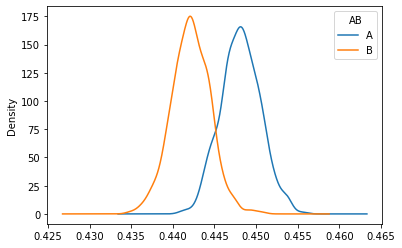

In [117]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(1000):
    boot_mean = data.sample(frac = 1,replace = True).groupby('AB')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='density')

Probability that 1-day retention is greater when the gate is at level 30(A): 0.965


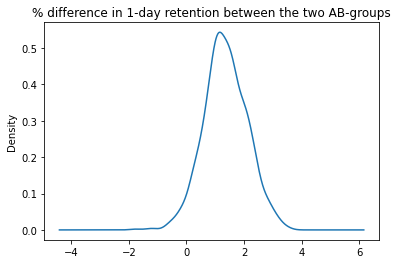

In [118]:
boot_1d['diff'] = (boot_1d.A - boot_1d.B)/boot_1d.B*100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='density')
ax.set_title('% difference in 1-day retention between the two AB-groups')

# Calculating the probability that 1-day retention is greater when the gate is at level 30
print('Probability that 1-day retention is greater when the gate is at level 30(A):',(boot_1d['diff'] > 0).mean())

## From this chart, we can see that the most likely % difference is around 1% - 2%, and that 95% of the distribution is above 0%, in favor of a gate at level 30.

In [119]:
## Retention_7

data.groupby('AB')['retention_7'].mean()

AB
A    0.190183
B    0.182000
Name: retention_7, dtype: float64

Probability that 7-day retention is greater when the gate is at level 30(A): 0.998


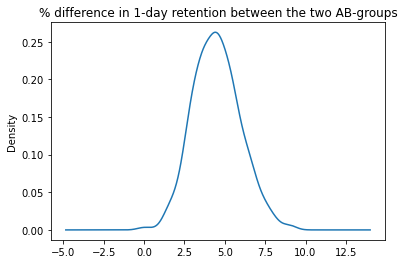

In [121]:
boot_7d = []
for i in range(1000):
    boot_mean = data.sample(frac = 1,replace = True).groupby('AB')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)
    
# A Kernel Density Estimate plot of the bootstrap distributions
## boot_7d.plot(kind='density')
boot_7d['diff'] = (boot_7d.A - boot_7d.B)/boot_7d.B*100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind='density')
ax.set_title('% difference in 1-day retention between the two AB-groups')

# Calculating the probability that 1-day retention is greater when the gate is at level 30
print('Probability that 7-day retention is greater when the gate is at level 30(A):',(boot_7d['diff'] > 0).mean())

## From this chart, we can see that the most likely % difference is around 4% - 5%, and that 99.8% of the distribution is above 0%, in favor of a gate at level 30.